In [14]:
import requests
from pymongo import MongoClient
from urllib.parse import urljoin
from pprint import pprint
import nltk
import json

# Retrieve Lyrics Via API

In [2]:
# DB CONFIG
client = MongoClient('mongo', 27017)
db = client.music_db
songs_collection = db.songs

In [3]:
# Pull all songs from DB
songs = list(songs_collection.find())

In [4]:
def has_lyrics(song):
    if not song.get('lyrics'):
        return False
    
    if song.get('lyrics') == 'null':
        return False

    if song.get('lyrics').get('error'):
        return False
        
    
    return True

songs = [song for song in songs if has_lyrics(song)]

# Clean Lyrics

In [5]:
import re
import string
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from typing import List

STOPWORDS = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

def clean(word):
    chars = [char for char in word if char not in string.punctuation]  # Remove Punctuation
    word = "".join(chars)
    word = word.lower()   # Lowercase
    return word    


def tokenize_lyrics(lyrics: str):
    """ Takes lyrics in string format, returns list of words """
    replacement_patterns = (r'\[.*?\]',    # Between Brackets
                           )    
    lyrics_clean = re.sub('|'.join(replacement_patterns), '', lyrics)
    tokenizer = WhitespaceTokenizer()
    tokens = tokenizer.tokenize(lyrics_clean)
    
    # Split words with hyphens
    for word in tokens:
        if '-' in word:
            i = tokens.index(word)
            tokens = tokens[:i] + word.split('-') + tokens[i+1:]
        
    tokens = filter(lambda token: token != '', tokens)
    return list(tokens)


def is_stopword(word: str):
    return word in STOPWORDS


def tokenize(lyrics, stopwords=True, lemandstem=True):
    tokens = tokenize_lyrics(lyrics)
    tokens = map(clean, tokens)
    if stopwords:
        tokens = [word for word in tokens if not is_stopword(word)]
    if lemandstem:
        tokens = map(lemmatizer.lemmatize, tokens)
        tokens = map(stemmer.stem, tokens)
        tokens = map(lemmatizer.lemmatize, tokens)
    tokens = list(tokens)
    return tokens


def add_tokenization_to_track(track):
    track['lyrics']['tokens'] = tokenize(track['lyrics']['result']['track']['text'])
    return track
    
tokenizations = list(map(add_tokenization_to_track, songs))

# Associations

In [6]:
# Format properly
tokens = [track['lyrics']['tokens'] for track in tokenizations]

def join_tokens(tokens, group):
    new_tokens = []
    for i in range(0, len(tokens) - group):
        word_set = [tokens[i + j] for j in range(group)] 
        new_tokens.append(" ".join(word_set))
    return new_tokens

tokens = [join_tokens(tokenset, 2) for tokenset in tokens]

In [7]:
from mlxtend.frequent_patterns import apriori
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

dataset = tokens
te = TransactionEncoder()
oht_ary = te.fit(dataset).transform(dataset, sparse=True)
df = pd.SparseDataFrame(oht_ary, columns=te.columns_, default_fill_value=False)

In [8]:
frequent_itemsets = apriori(df, min_support=.7, use_colnames=True)

KeyboardInterrupt: 

In [ ]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(len)
frequent_itemsets

In [ ]:
def itemset_by_length(df, length):
    length_itemsets = df[(df['length'] == length)].sort_values(by='support', ascending=False)
    return length_itemsets

itemset_by_length(frequent_itemsets, 1)

# New

In [37]:
from collections import Counter
from pandas import DataFrame

def songs_by(artist):
    return [song for song in songs if artist == song['artist']]

drake = songs_by('Drake')
eminem = songs_by('Eminem')

def songs_to_counts(songs: List[List[str]]):
    word_counts = Counter()
    for song in songs:
        word_counts.update(Counter(song))
    return word_counts

def token_list(track):
    return track['lyrics']['tokens']

tokens = list(map(token_list, eminem))
counts = songs_to_counts(tokens)
total = sum(counts.values())

df = DataFrame.from_dict(counts, orient='index', columns=['count'])
df['frequency'] = df['count'].apply(lambda x: x/total)
df.sort_values(by='frequency', ascending=False)


,count,frequency
im,260,0.024579
like,163,0.015409
dont,125,0.011817
go,119,0.011250
get,117,0.011061
caus,109,0.010304
know,90,0.008508
back,84,0.007941
cant,78,0.007374
ah,76,0.007185


In [161]:
one = songs_by('Rihanna')
two = songs_by('Kendrick Lamar')

num_docs = 5

one_tokens = list(map(token_list, one))
two_tokens = list(map(token_list, two))

one_docs = list(map(" ".join, one_tokens))[:num_docs]
two_docs = list(map(" ".join, two_tokens))[:num_docs]


In [162]:
from sklearn.feature_extraction.text import TfidfVectorizer
documents = one_docs + two_docs
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
print(tfidf_matrix.shape)


(10, 776)


In [163]:
from sklearn.metrics import pairwise

similarity = pairwise.cosine_similarity(tfidf_matrix, tfidf_matrix)

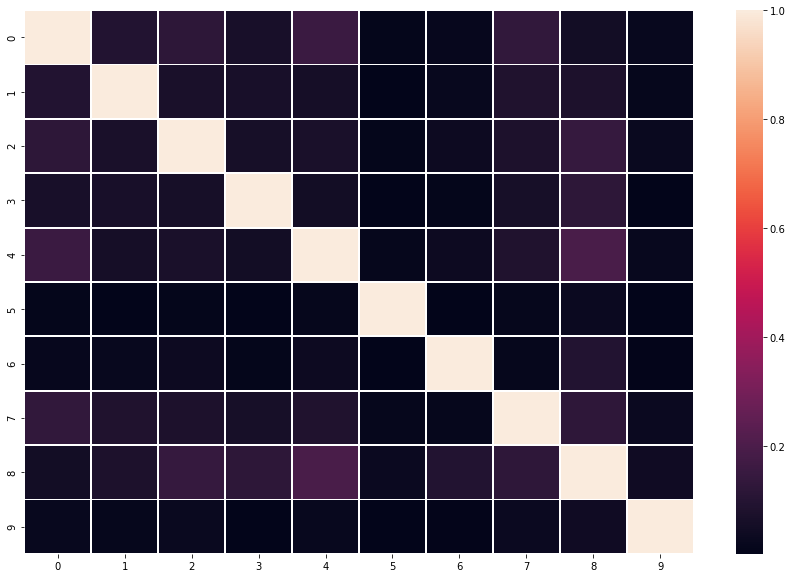

In [164]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

plt.figure(figsize=(15,10))
ax = sns.heatmap(similarity, linewidth=0.8)
plt.show()
